# Super Resolution Convoluutional Neural Network for Image Restoration

During this project, we learn how to implement:

1. use the PSNR, MSE and SSIM image quality metrics.
2. process images using OpenCV.
3. convert between the RGB, BGR and YCrCb color spaces.
4. build deep neural networks in Keras.
5. deploy and evalute the SCRNN network.

In [2]:
import sys
import keras
import numpy
import matplotlib
import skimage
import cv2
import tensorflow as tf

Using TensorFlow backend.


In [3]:
# import some necessary packages

from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras.optimizers import SGD, Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# python magic function
%matplotlib inline

In [4]:
# now we are define a function for peak signal-to-noise ration (PSNR)

def psnr(target, ref):
    
    
    # assume RGB/BGR image
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255. / rmse)

# now we defined function for mean squared error (NSE)

def mse(target, ref):
    
    # NSE is the sum of the squared difference between the two images
    
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    
    return err

# now we are create the function which combine the all the images quality matrices

def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


In [34]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [35]:
prepare_images('source/', 2)

Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving head_GT.bmp
Saving bridge.bmp
Saving zebra.bmp
Saving foreman.bmp
Saving baboon.bmp
Saving flowers.bmp
Saving face.bmp
Saving woman_GT.bmp
Saving man.bmp
Saving pepper.bmp
Saving baby_GT.bmp
Saving comic.bmp
Saving bird_GT.bmp
Saving monarch.bmp
Saving ppt3.bmp
Saving lenna.bmp
Saving barbara.bmp


In [36]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/home/thenandkishor/anaconda3/envs/opencv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 42508315.0
SSIM: 0.8791344763843051

coastguard.bmp
PSNR: 27.161600663887082
MSE: 38016900.0
SSIM: 0.756950063354931

head_GT.bmp
PSNR: 31.020502848237534
MSE: 12091144.0
SSIM: 0.8011121330733371

bridge.bmp
PSNR: 25.850528790115554
MSE: 132950097.0
SSIM: 0.7804245912255268

zebra.bmp
PSNR: 27.909840639329513
MSE: 72325580.0
SSIM: 0.8911656209329116

foreman.bmp
PSNR: 30.14456532664372
MSE: 19128470.0
SSIM: 0.933268417388899

baboon.bmp
PSNR: 22.157084083442548
MSE: 284907872.0
SSIM: 0.629277587900277

flowers.bmp
PSNR: 27.454504805386144
MSE: 63449720.0
SSIM: 0.8697286286974628

face.bmp
PSNR: 30.99220650287191
MSE: 11824945.0
SSIM: 0.8008439492289884

woman_GT.bmp
PSNR: 29.326236280817465
MSE: 17867808.0
SSIM: 0.9335397280466592

man.bmp
PSNR: 27.22646369798821
MSE: 96849006.0
SSIM: 0.8214950645456561

pepper.bmp
PSNR: 29.88947161686106
MSE: 52455904.0
SSIM: 0.8357937568464359

baby_GT.bmp
PSNR: 34.371806409661986
MSE: 18687917.0
SSIM: 0

In [48]:
# define the SCRNN models

def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [49]:
#define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [50]:
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

/home/thenandkishor/anaconda3/envs/opencv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 32.9717779215716
MSE: 7469054.0
SSIM: 0.9532838164378017

Reconstructed Image: 
PSNR: 36.54721180087329
MSE: 3278855.0
SSIM: 0.9693544755927612



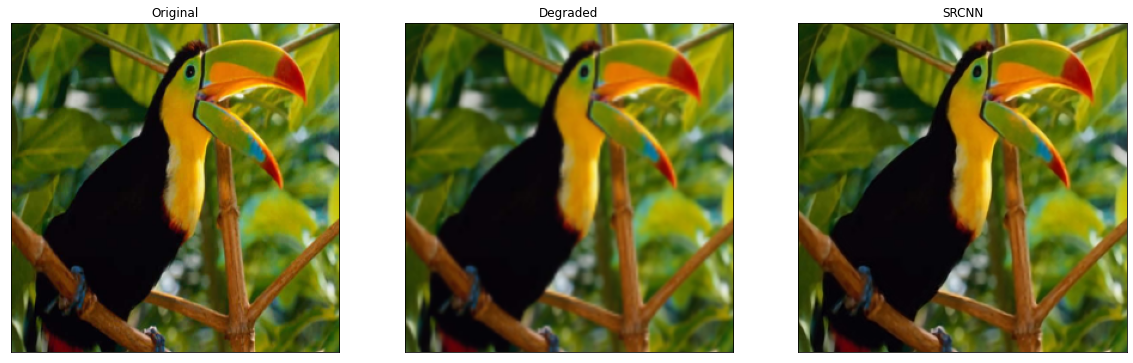

In [52]:
ref, degraded, output, scores = predict('images/bird_GT.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [44]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

/home/thenandkishor/anaconda3/envs/opencv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving head_GT.bmp
Saving bridge.bmp
Saving zebra.bmp
Saving foreman.bmp
Saving baboon.bmp
Saving flowers.bmp
Saving face.bmp
Saving woman_GT.bmp
Saving man.bmp
Saving pepper.bmp
Saving baby_GT.bmp
Saving comic.bmp
Saving bird_GT.bmp
Saving monarch.bmp
Saving ppt3.bmp
Saving lenna.bmp
Saving barbara.bmp
